In [42]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
img = imread("C:/Users/stan2/Documents/4A/Comp Imaging/MinCut-MaxFlow/dataset/images/65019.jpg")
img_gt = imread("C:/Users/stan2/Documents/4A/Comp Imaging/MinCut-MaxFlow/dataset/images-gt/65019.png")

img_label = imread("C:/Users/stan2/Documents/4A/Comp Imaging/MinCut-MaxFlow/dataset/images-labels/65019-anno.png")


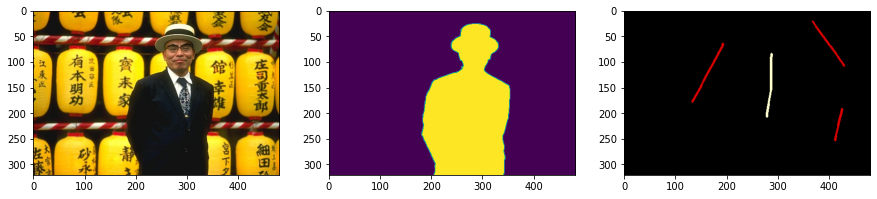

In [2]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(131)
ax1.imshow(img)
ax2 = fig.add_subplot(132)
ax2.imshow(img_gt)
ax3 = fig.add_subplot(133)
ax3.imshow(img_label)

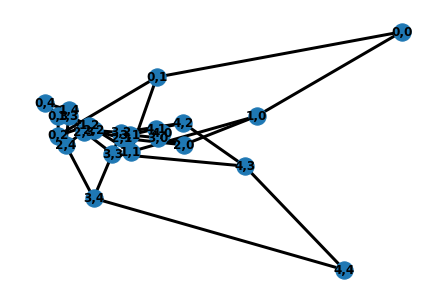

In [29]:
import networkx as nx
import random
from math import *
G = nx.Graph()
nbx = 5
nby = 5
nodes = [str(i)+","+str(j) for i in range(nbx) for j in range(nby)]
G.add_nodes_from(nodes, terminal = None, parent = None)
G.add_weighted_edges_from([(str(i)+","+str(j),str(i+1)+","+str(j),exp(abs(i+j+2-nbx))) for i in range(nbx-1) for j in range(nby)])
G.add_weighted_edges_from([(str(i)+","+str(j),str(i)+","+str(j+1),exp(abs(i+j+1-nbx))) for i in range(nbx) for j in range(nby-1)])
nx.set_edge_attributes(G, 'black', "color")
nx.draw_kamada_kawai(G, edge_color = nx.get_edge_attributes(G,'color').values(), width=3, with_labels=True, font_weight='bold')

In [4]:
def grow(Graph, Active):
    while len(Active)>0:
        node_name = Active.pop()
        node = Graph.nodes[node_name]
        terminal = node['terminal']
        if terminal != None:
            for neighbor_name in Graph[node_name]:
                neighbor = Graph.nodes[neighbor_name]
                if neighbor['terminal'] == None:
                    Active.insert(0,neighbor_name)
                    neighbor['terminal'] = terminal
                    neighbor['parent'] = node_name
                    Graph[node_name][neighbor_name]['color'] = (terminal=='S' and 'r') or 'b'
                if neighbor['terminal'] != terminal:
                    Active.append(node_name)
                    return(node_name,neighbor_name)
    return None

def get_path_flow(Graph, initial_node):
    max_flow = inf
    node_name = initial_node
    path = [node_name]
    node = Graph.nodes[node_name]
    while not node['parent'] in ['S','T']:
        parent_name = node['parent']
        parent = Graph.nodes[parent_name]
        max_flow = min(Graph[node_name][parent_name]['weight'],max_flow)
        path += [parent_name]
        node_name=parent_name
        node = parent
    return path,max_flow

def augment(Graph,path,max_flow):
    Orphans = []
    for i in range(len(path)-1):
        node = path[i]
        next_node = path[i+1]
        Graph[node][next_node]['weight'] -= max_flow
        if Graph[node][next_node]['weight'] == 0:
            Graph.remove_edge(node,next_node)
            terminal = Graph.nodes[node]['terminal']
            if terminal == Graph.nodes[next_node]['terminal']:
                if terminal == 'S':
                    Graph.nodes[next_node]['parent'] = None
                    Orphans += [next_node]
                else:
                    Graph.nodes[node]['parent'] = None
                    Orphans += [node]

    return Orphans

def root(Graph,node):
    current = node
    parent = Graph.nodes[node]['parent']
    while not parent in ['S','T',None]:
        current = parent
        parent =  Graph.nodes[current]['parent']
    return current, parent

def adopt(Graph,Orphans,Active):
    while len(Orphans) != 0:
        node_name = Orphans.pop()
        node = Graph.nodes[node_name]
        children = []
        for neighbor_name in Graph[node_name]:
            neighbor = Graph.nodes[neighbor_name]
            assert node['terminal']
            if node['terminal'] == neighbor['terminal']:
                if neighbor['parent'] == node_name:
                    children.append(neighbor_name)
                elif root(Graph, neighbor_name)[0] != node_name:
                    node['parent'] = neighbor_name
                    Graph[node_name][neighbor_name]['color'] = (node['terminal']=='S' and 'r') or 'b'
                    break
                Active.insert(0,neighbor_name)
        Active = list(filter(lambda n: n!=node_name, Active))
        if (node['parent'] == None):
            for child in children:
                Graph.nodes[child]['parent'] = None
                Graph[node_name][child]['color'] = 'black'
            Orphans += children
            node['terminal'] = None
    return

In [5]:
G.nodes['0,0']['terminal'] = "S"
G.nodes['4,4']['terminal'] = "T"
G.nodes['0,0']['parent'] = "S"
G.nodes['4,4']['parent'] = "T"
A = ['0,0','4,4']
n1, n2 = grow(G,A)
path1, maxflow1 = get_path_flow(G,n1)
path2, maxflow2 = get_path_flow(G,n2)
print(path1[::-1]+path2, min(maxflow1, maxflow2))
O = augment(G,path1[::-1]+path2,min(maxflow1, maxflow2, G[n1][n2]['weight']))
# print(O)
adopt(G,O,A)

['0,0', '1,0', '2,0', '3,0', '4,0', '4,1', '4,2', '4,3', '4,4'] 1.0


In [6]:
n1, n2 = grow(G,A)


In [7]:

path1, maxflow1 = get_path_flow(G,n1)
path2, maxflow2 = get_path_flow(G,n2)
print(path1[::-1]+path2, min(maxflow1, maxflow2))
O = augment(G,path1[::-1]+path2,min(maxflow1, maxflow2, G[n1][n2]['weight']))

['0,0', '1,0', '2,0', '3,0', '4,0', '4,1', '3,1', '3,2', '3,3', '3,4', '4,4'] 0.22140275816016985


In [8]:
adopt(G,O,A)

In [9]:
print(n1,n2)
print(G.nodes['0,0'],G.nodes['0,1'])

3,0 4,0
{'terminal': 'S', 'parent': 'S'} {'terminal': 'S', 'parent': '0,0'}


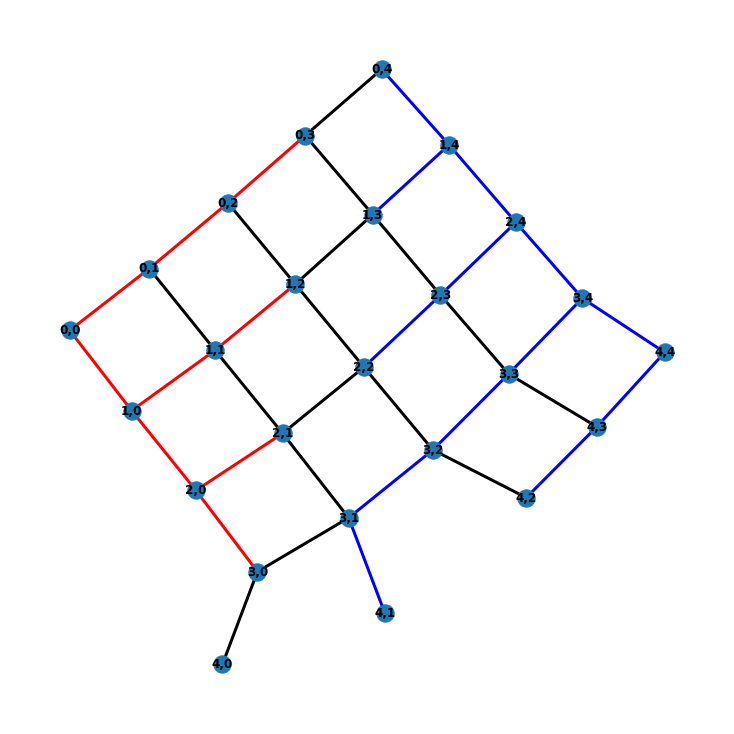

In [11]:
fig = plt.figure(figsize=(10,10))
G_draw = G.copy()
nx.set_edge_attributes(G_draw, 1, "weight")
nx.draw_kamada_kawai(G_draw, edge_color = nx.get_edge_attributes(G,'color').values(), width=3, with_labels=True, font_weight='bold')

In [30]:
def max_cut_min_flow(Graph, S, T):
    graphs = [Graph.copy()]
    for t in T:
        Graph.nodes[t]['terminal'] = 'T'
        Graph.nodes[t]['parent'] = 'T'
    for t in S:
        Graph.nodes[t]['terminal'] = 'S'
        Graph.nodes[t]['parent'] = 'S'
    active = S+T
    touching_nodes = grow(Graph,active)
    while touching_nodes:
        n1, n2 = touching_nodes
        path1, maxflow1 = get_path_flow(Graph,n1)
        path2, maxflow2 = get_path_flow(Graph,n2)
        if Graph.nodes[n1]['terminal'] == 'S':
            path = path1[::-1]+path2
        else:
            path = path2[::-1]+path1
        orphans = augment(Graph,path,min(maxflow1, maxflow2, Graph[n1][n2]['weight']))
        adopt(Graph,orphans,active)
        touching_nodes = grow(Graph,active)
        graphs += [Graph.copy()]
    return(graphs)

graph = G.copy()
graphs = max_cut_min_flow(graph,['0,0'],['4,4'])


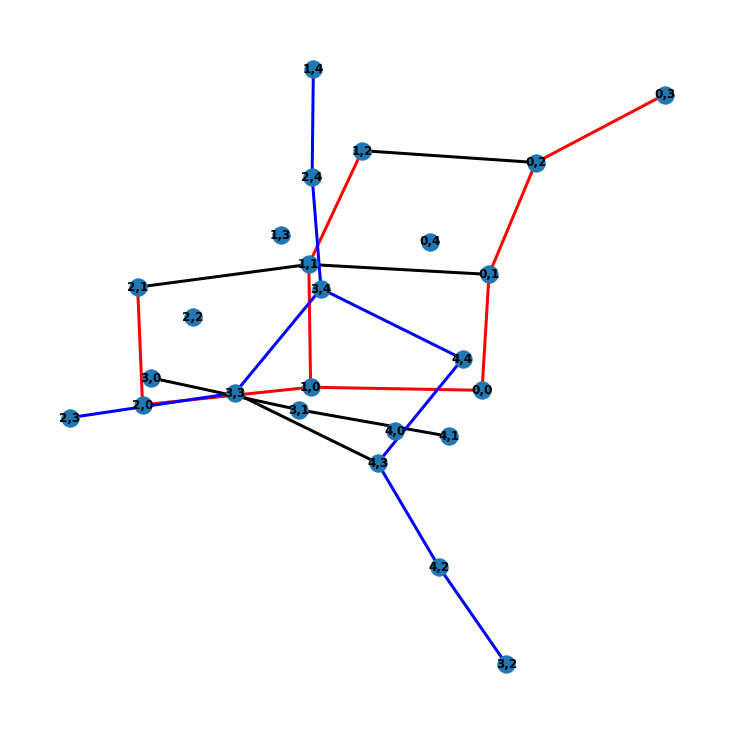

In [39]:
fig = plt.figure(figsize=(10,10))
G_draw = graphs[-1].copy()
nx.set_edge_attributes(G_draw, 1, "weight")
nx.draw_kamada_kawai(G_draw, edge_color = nx.get_edge_attributes(G_draw,'color').values(), width=3, with_labels=True, font_weight='bold')

In [22]:
graphs[-2]['4,3']['3,3']

{'weight': 1.216348385502565, 'color': 'b'}

In [69]:
def get_cut(G,width,height):
    segmentation = np.zeros((width,height))
    for x in range(width):
        for y in range(height):
            if graph.nodes[str(x)+','+str(y)]['terminal'] == 'S':
                segmentation[x,y] = 1
    return segmentation

def dice_score(seg_1, seg_2):
    n1 = len(seg_1.flatten())
    n2 = len(seg_2.flatten())
    assert n1 == n2
    unique, count = np.unique(seg_1[seg_1==seg_2], return_counts=True)
    intersection_nb = count[list(unique).index(1)]
    return 2*intersection_nb/(n1+n2)


seg = get_cut(graphs[-1], 5, 5)
print(seg, dice_score(np.ones((5,5)),seg))

[[1. 1. 1. 1. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]] 0.36
